# Bank Customer Churn Analysis & Recall‑Tuned XGBoost Model
Author: Victor Wei • Created: 2025-06-05



This notebook walks through an **end‑to‑end workflow** for predicting **bank customer churn**
with a **recall‑optimised XGBoost model** and shows how to translate the scores into
profitable retention tactics.

**Workflow**
1. Data loading & initial inspection  
2. Exploratory Data Analysis (EDA)  
3. Multicollinearity diagnostics  
4. Encoding strategies  
5. Baseline model comparison (RF, LightGBM, XGBoost)  
6. Hyper‑parameter tuning to *maximise recall* with XGBoost  
7. Cross‑validated performance summary  
8. *Using the ranking power* & *personalising interventions* (business playbook)


## 1  Load and Inspect Data

In [1]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, scipy.stats as stats
pd.set_option("display.max_columns", None)

colors = ["#2c3e50", "#34495e", "#7f8c8d", "#e74c3c", "#c0392b"]
ordered_colors = [colors[0], colors[3], colors[2], colors[1], colors[4]]

df = pd.read_csv("data/train.csv")
print("Shape:", df.shape)
print(df.columns.tolist())
df.head()

Shape: (15000, 14)
['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15709511.0,Ch'ang,754.0,Spain,Male,40.0,8.0,102954.68,2.0,1.0,1.0,149238.35,0.0
1,1,15592761.0,Genovese,579.0,France,Female,28.0,1.0,0.00,2.0,1.0,0.0,64869.32,0.0
2,2,15579914.0,Yeh,744.0,France,Female,56.0,5.0,0.00,1.0,1.0,0.0,158816.03,1.0
3,3,15669611.0,Nwachinemelu,697.0,France,Male,29.0,2.0,0.00,2.0,1.0,0.0,55775.72,0.0
4,4,15761775.0,Hs?eh,628.0,France,Female,22.0,9.0,0.00,2.0,1.0,0.0,49653.39,0.0


In [2]:
df = df.drop(columns=['id','CustomerId','Surname']); df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      15000 non-null  float64
 1   Geography        15000 non-null  object 
 2   Gender           15000 non-null  object 
 3   Age              15000 non-null  float64
 4   Tenure           15000 non-null  float64
 5   Balance          15000 non-null  float64
 6   NumOfProducts    15000 non-null  float64
 7   HasCrCard        15000 non-null  float64
 8   IsActiveMember   15000 non-null  float64
 9   EstimatedSalary  15000 non-null  float64
 10  Exited           15000 non-null  float64
dtypes: float64(9), object(2)
memory usage: 1.3+ MB


## 2  Exploratory Data Analysis

In [3]:
print('Churn rate:', df['Exited'].value_counts(normalize=True))

Churn rate: Exited
0.0    0.796133
1.0    0.203867
Name: proportion, dtype: float64


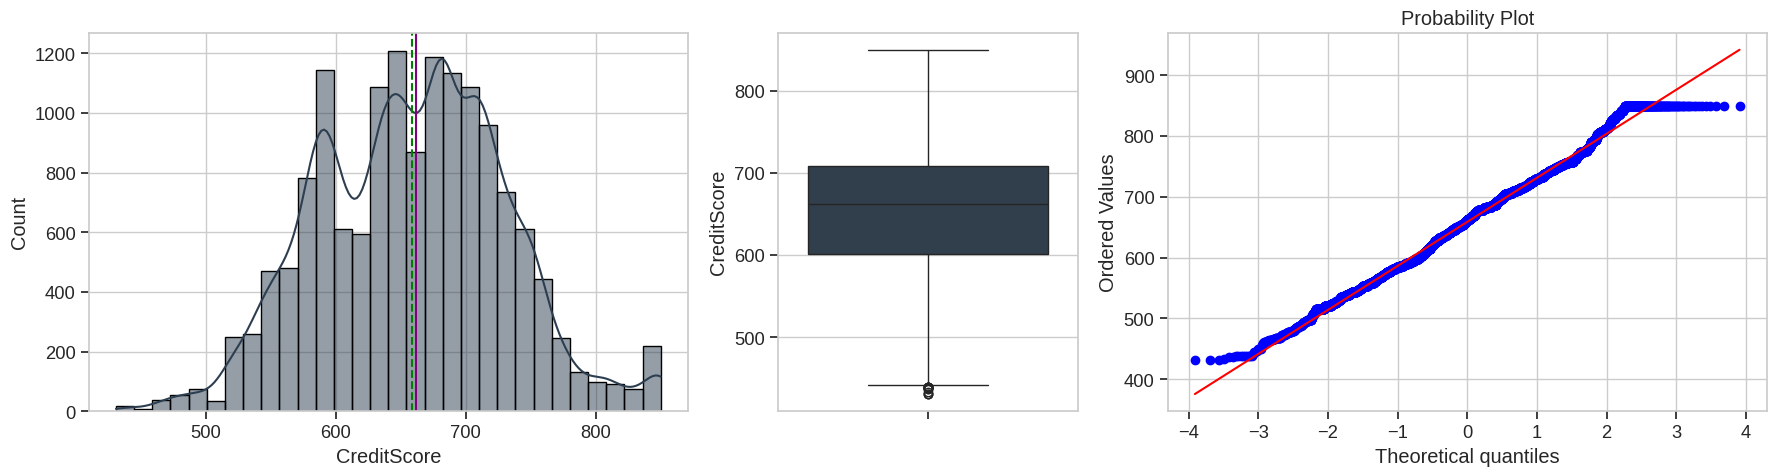

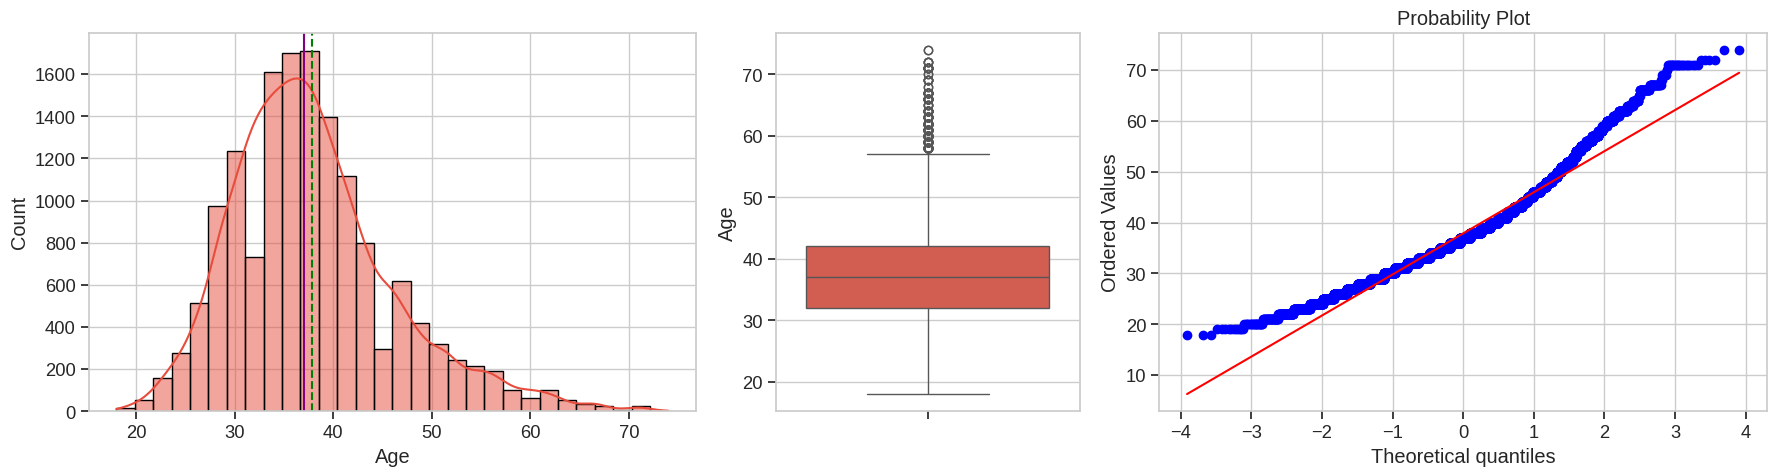

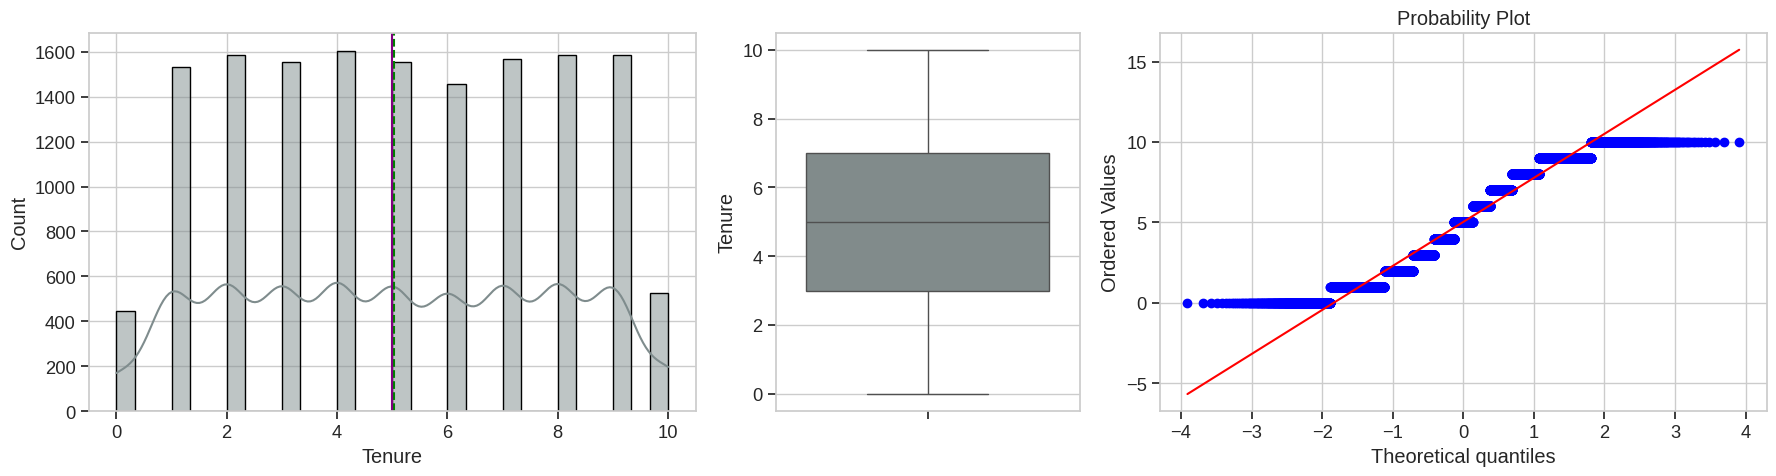

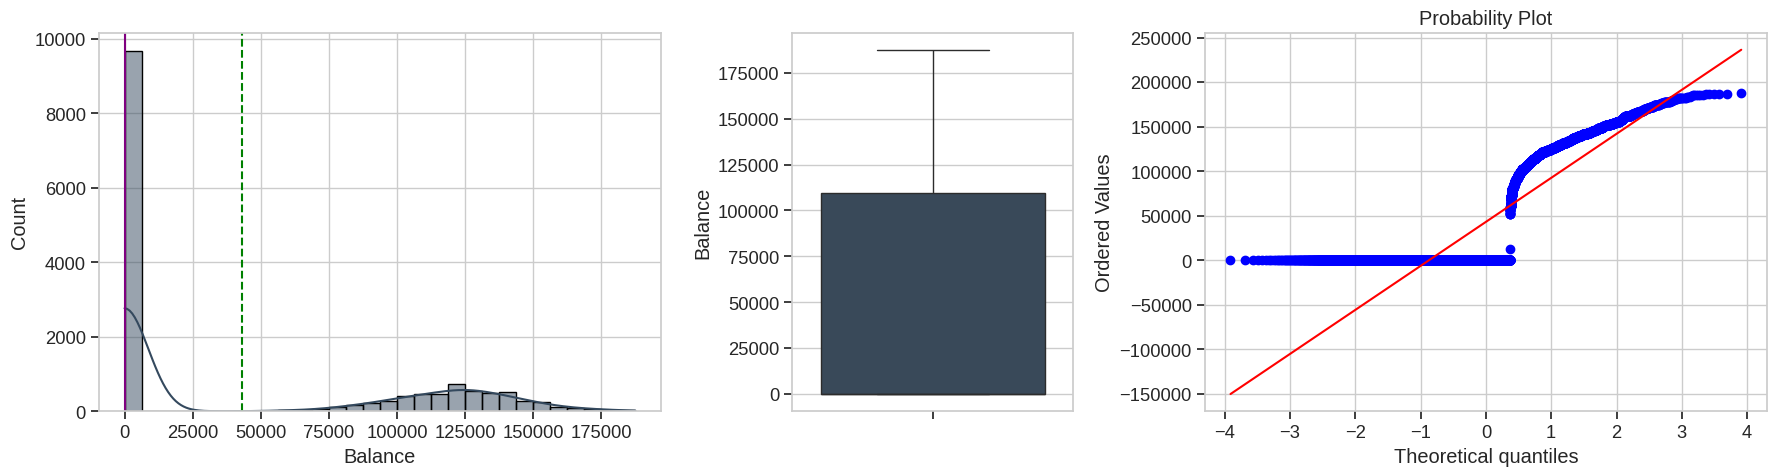

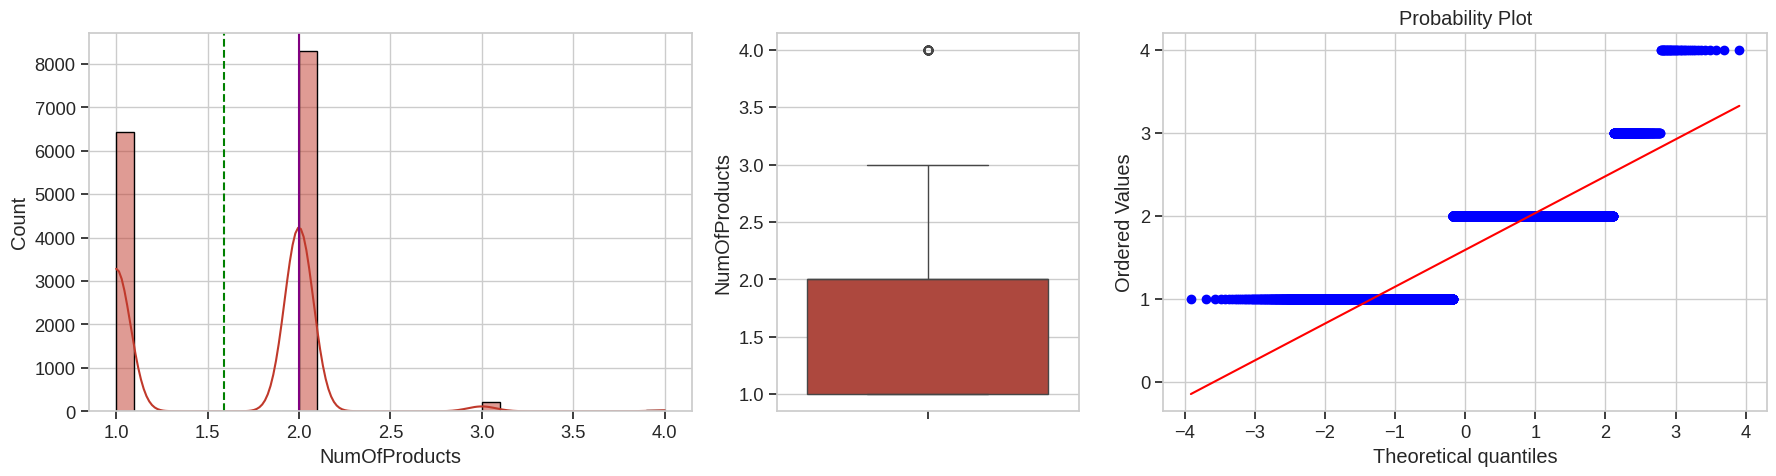

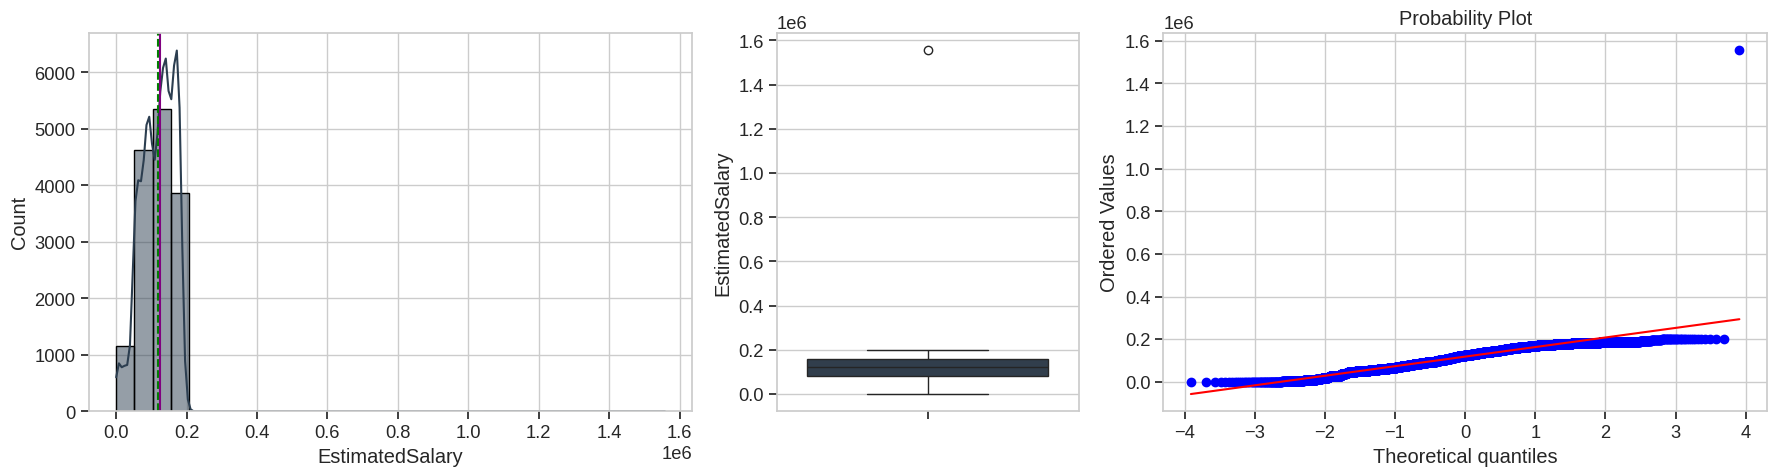

In [4]:
numeric = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']
def plot_distributions(data):
    cols = data.columns
    ext = (ordered_colors * (len(cols)//len(ordered_colors)+1))[:len(cols)]
    plt.style.use('seaborn-v0_8-whitegrid'); sns.set_context('notebook', font_scale=1.2)
    for i,col in enumerate(cols):
        fig,ax=plt.subplots(1,3,figsize=(18,5),gridspec_kw={'width_ratios':[2,1,2]})
        sns.histplot(data[col], kde=True, color=ext[i], ax=ax[0], bins=30)
        ax[0].axvline(data[col].mean(), color='g', ls='--'); ax[0].axvline(data[col].median(), color='purple')
        sns.boxplot(y=data[col], ax=ax[1], color=ext[i])
        stats.probplot(data[col], dist='norm', plot=ax[2])
        plt.tight_layout(); plt.show()
plot_distributions(df[numeric])

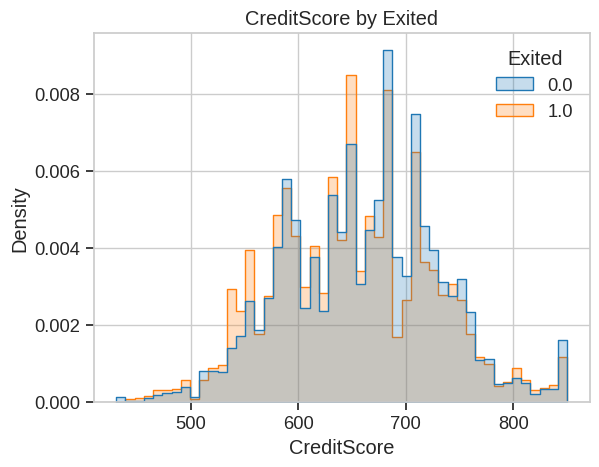

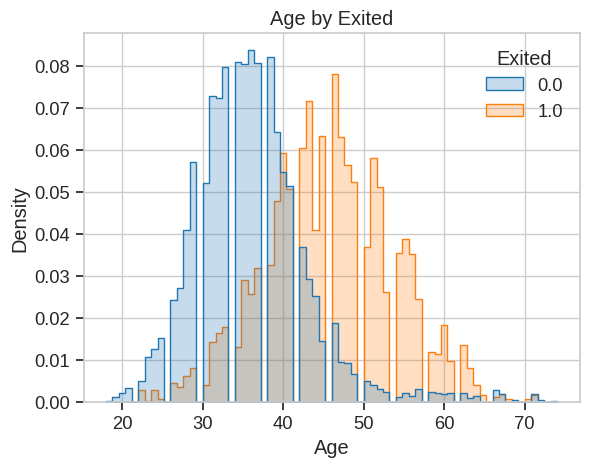

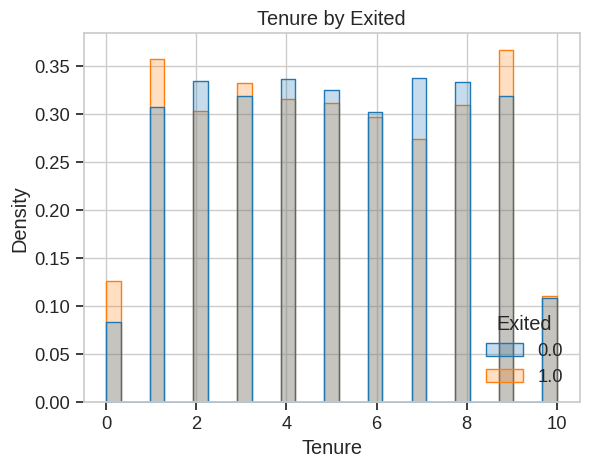

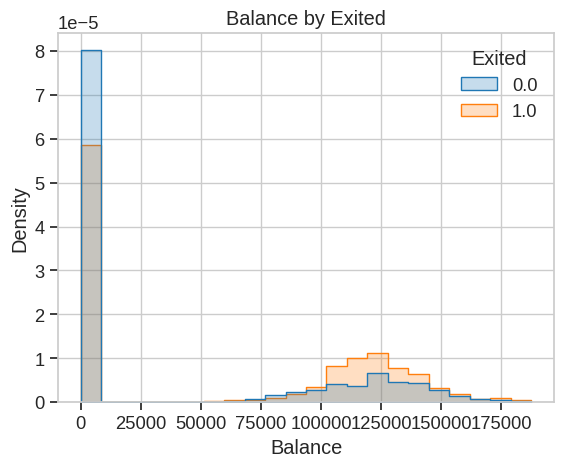

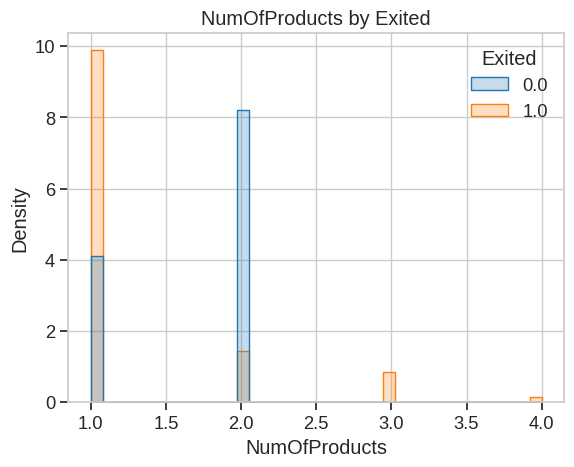

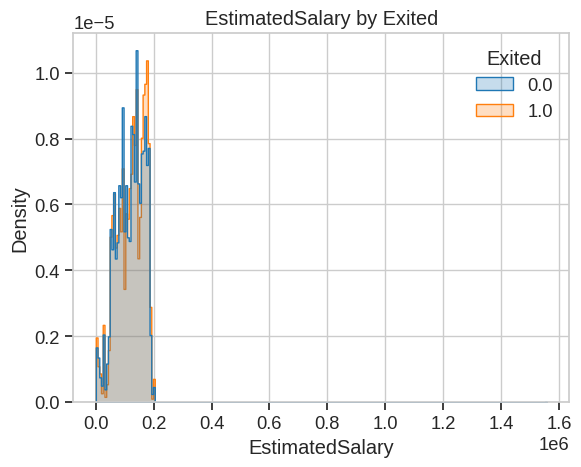

In [5]:
for col in numeric:
    sns.histplot(data=df, x=col, hue='Exited', stat='density', common_norm=False, element='step')
    plt.title(f'{col} by Exited'); plt.show()

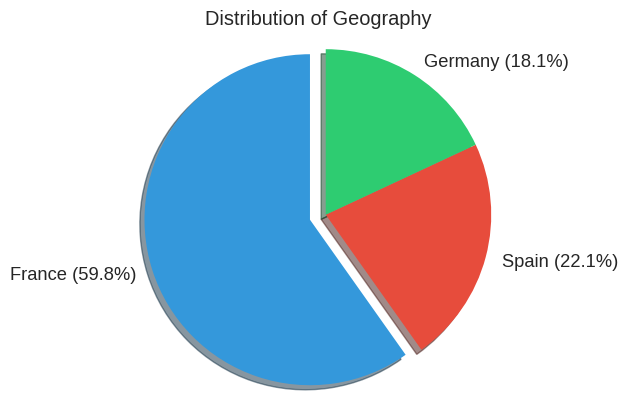

| Geography   |   Count |    % |
|-------------|---------|------|
| France      |    8971 | 59.8 |
| Spain       |    3321 | 22.1 |
| Germany     |    2708 | 18.1 |


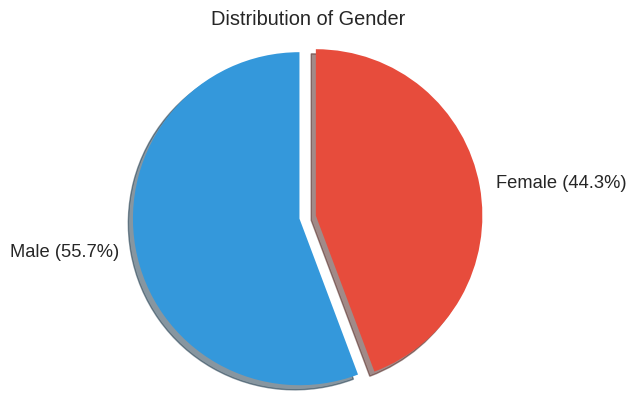

| Gender   |   Count |    % |
|----------|---------|------|
| Male     |    8358 | 55.7 |
| Female   |    6642 | 44.3 |


In [6]:
categorical = ['Geography','Gender']
from tabulate import tabulate
def plot_cats(data):
    sns.set_palette(['#3498db','#e74c3c','#2ecc71','#f1c40f','#9b59b6'])
    for col in data.columns:
        cnt = data[col].value_counts(); pct = cnt/len(data)*100
        plt.pie(cnt, labels=[f'{k} ({v:.1f}%)' for k,v in pct.items()], explode=[0.1]+[0]*(len(cnt)-1), startangle=90, shadow=True)
        plt.title(f'Distribution of {col}'); plt.axis('equal'); plt.show()
        print(tabulate(pd.DataFrame({'Count':cnt, '%':pct.round(1)}), headers=[col,'Count','%'], tablefmt='github'))
plot_cats(df[categorical])

,count,churn_rate
Geography,,
Germany,2708,0.419867
Spain,3321,0.158988
France,8971,0.155278


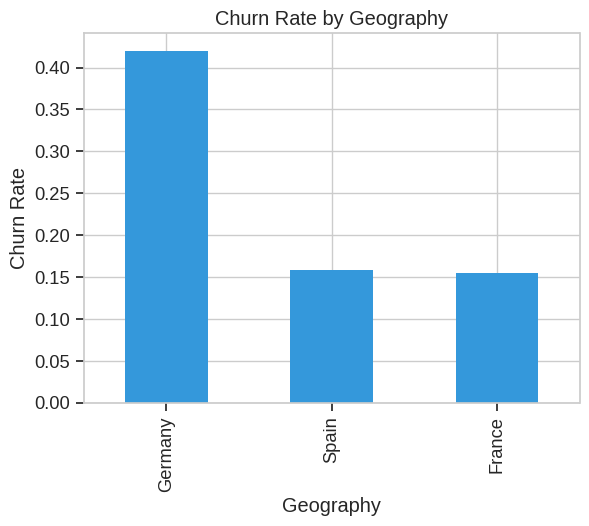

,count,churn_rate
Gender,,
Female,6642,0.283047
Male,8358,0.140943


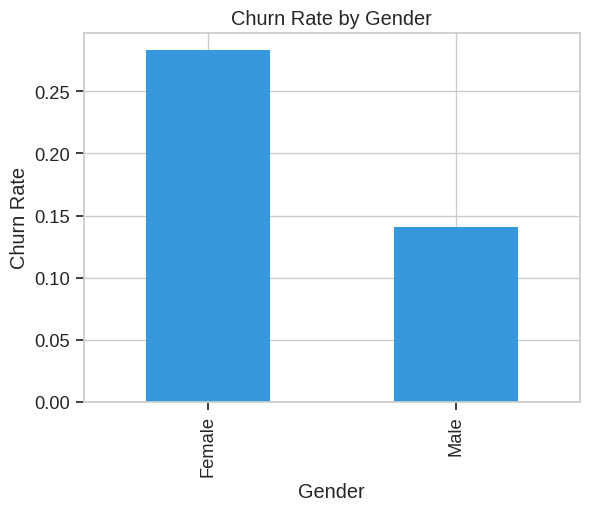

In [8]:
for col in categorical:
    grp = df.groupby(col)['Exited'].agg(count='count', churn_rate='mean').sort_values('churn_rate', ascending=False)
    display(grp); grp['churn_rate'].plot(kind='bar'); plt.ylabel('Churn Rate'); plt.title(f'Churn Rate by {col}'); plt.show()

### 2.3  Correlation & Multicollinearity

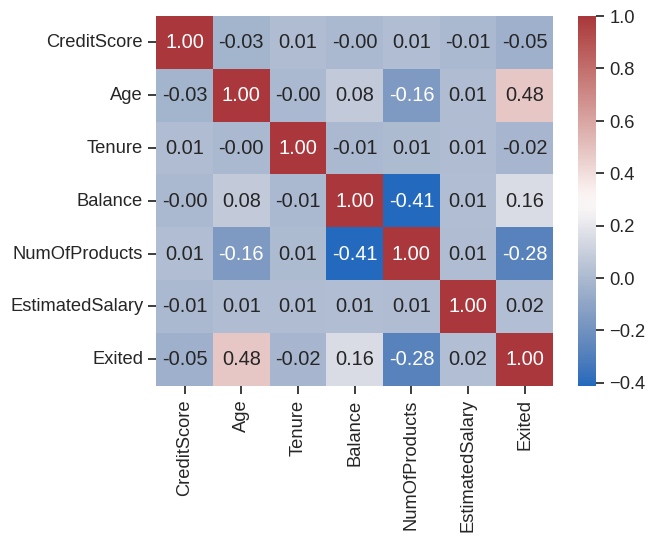

,feature,VIF
0,CreditScore,30.854317
1,Age,17.837811
4,NumOfProducts,10.530242
5,EstimatedSalary,7.044724
2,Tenure,4.123588
3,Balance,1.778347


In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
corr = df[numeric+['Exited']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='vlag'); plt.show()
vif_df = pd.DataFrame({'feature':numeric,
                       'VIF':[variance_inflation_factor(df[numeric].values,i) for i in range(len(numeric))]})
vif_df.sort_values('VIF', ascending=False)

> **Why Multicollinearity Matters**  
> • Logistic regression coefficients can swing wildly & standard errors inflate.  
> • Tree models handle it better but their feature importances split across collinear twins.

## 3  Feature Encoding Strategies

In [11]:
Y = df['Exited']; X_raw = df.drop(columns=['Exited'])
cat_cols = X_raw.select_dtypes(include=['object','category']).columns.tolist()+['HasCrCard','IsActiveMember']

# A) Full one‐hot encoding for tree models (keep all levels)
X_ohe_full = pd.get_dummies(
    X_raw,
    columns=cat_cols,
    drop_first=False
)

# B) Reduced one‐hot encoding for linear models (drop first level)
X_ohe_drop = pd.get_dummies(
    X_raw,
    columns=cat_cols,
    drop_first=True
)

# C) Label encoding for tree models (compact integer codes)
from sklearn.preprocessing import OrdinalEncoder
ord_enc = OrdinalEncoder()
X_label = X_raw.copy()
X_label[cat_cols] = ord_enc.fit_transform(X_raw[cat_cols])

# D) Stratified K-Fold(leak-safe) target encoding for all categorical features
from sklearn.model_selection import StratifiedKFold
X_target = X_raw.copy()

# Create empty columns for target‐encoded values
for col in cat_cols:
    X_target[f"{col}_target_enc"] = np.nan

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10000)
global_mean = Y.mean()

for col in cat_cols:
    for train_idx, val_idx in skf.split(X_raw, Y):
        # Compute category means on the "train" portion
        means = (
            Y.iloc[train_idx]
             .groupby(X_raw[col].iloc[train_idx])
             .mean()
        )
        # Map those means onto the "validation" portion
        X_target.loc[
            X_raw.index[val_idx],
            f"{col}_target_enc"
        ] = X_raw.loc[X_raw.index[val_idx], col].map(means)
    # Fill NaNs (unseen categories) with global mean
    X_target[f"{col}_target_enc"] = X_target[f"{col}_target_enc"].fillna(global_mean)

# Drop original categorical columns, keep only target‐encoded versions
X_target.drop(columns=cat_cols, inplace=True)

# Inspect shapes
print("X_ohe_full shape:", X_ohe_full.shape)
print("X_ohe_drop shape:", X_ohe_drop.shape)
print("X_label    shape:", X_label.shape)
print("X_target   shape:", X_target.shape)

X_ohe_full shape: (15000, 15)
X_ohe_drop shape: (15000, 11)
X_label    shape: (15000, 10)
X_target   shape: (15000, 10)


## 4  Baseline Model Comparison

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def eval_model(X, y, model):
    cv = StratifiedKFold(5, shuffle=True, random_state=42)
    pr, rc, f1, auc = [],[],[],[]
    for tr,vl in cv.split(X,y):
        model.fit(X.iloc[tr], y.iloc[tr])
        p = model.predict(X.iloc[vl]); prob = model.predict_proba(X.iloc[vl])[:,1]
        pr.append(precision_score(y.iloc[vl],p)); rc.append(recall_score(y.iloc[vl],p))
        f1.append(f1_score(y.iloc[vl],p)); auc.append(roc_auc_score(y.iloc[vl],prob))
    return np.mean(pr),np.mean(rc),np.mean(f1),np.mean(auc)

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42)
for name,Xmat in [('One‑hot',X_ohe_full), ('Label',X_label), ('Target',X_target)]:
    pr,rc,f1,auc = eval_model(Xmat, Y, rf)
    print(f'{name:<8}  Precision {pr:.3f} | Recall {rc:.3f} | F1 {f1:.3f} | AUC {auc:.3f}')

One‑hot   Precision 0.802 | Recall 0.635 | F1 0.708 | AUC 0.925
Label     Precision 0.807 | Recall 0.640 | F1 0.713 | AUC 0.926
Target    Precision 0.806 | Recall 0.642 | F1 0.715 | AUC 0.925


**Observation**  
Target encoding produced the highest mean F1 while label encoding was a close second. However, label encoding give us a much higher and stablize recall

We proceed with **label encoding** for gradient‑boosting models because we want to maximizes recall.

In [15]:
import lightgbm as lgb, xgboost as xgb
cv = StratifiedKFold(5, shuffle=True, random_state=42)
for name,model in {
    'RF': rf,
    'LightGBM': lgb.LGBMClassifier(objective='binary', n_estimators=200, class_weight='balanced', n_jobs=-1, random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(objective='binary:logistic', n_estimators=200, learning_rate=0.05,
                                 max_depth=6, scale_pos_weight=1.0/Y.mean(), eval_metric='logloss',
                                 n_jobs=-1, random_state=42)
}.items():
    pr,rc,f1,auc = eval_model(X_label,Y,model); print(f'{name:<9} Precision {pr:.3f} | Recall {rc:.3f} | F1 {f1:.3f} | AUC {auc:.3f}')

RF        Precision 0.807 | Recall 0.640 | F1 0.713 | AUC 0.926
LightGBM  Precision 0.666 | Recall 0.802 | F1 0.728 | AUC 0.927
XGBoost   Precision 0.622 | Recall 0.845 | F1 0.716 | AUC 0.931


*XGBoost shows the highest recall — our business goal.*

## 5  Hyper‑parameter Tuning for Maximum Recall (XGBoost)

In [16]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
xgb_base = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', n_jobs=-1, random_state=42)
param_dist = dict(
    n_estimators=[100,200,400], max_depth=[4,6,8,10], learning_rate=[0.01,0.05,0.1],
    subsample=[0.6,0.8,1.0], colsample_bytree=[0.6,0.8,1.0], scale_pos_weight=[1,3,5,10]
)
search = RandomizedSearchCV(xgb_base, param_dist, n_iter=100, scoring='recall',
                            cv=StratifiedKFold(4, shuffle=True, random_state=42),
                            n_jobs=-1, random_state=42, verbose=1)
search.fit(X_label, Y); print('Best params:', search.best_params_)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
Best params: {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [17]:
from sklearn.metrics import make_scorer, average_precision_score
from sklearn.model_selection import cross_validate

best_params = search.best_params_
clf = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='auc',
    random_state=42, n_jobs=-1, **best_params
)

scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score),
    'roc_auc': 'roc_auc',
    'average_precision': make_scorer(average_precision_score)
}

cv_results = cross_validate(clf, X_label, Y, cv=cv, scoring=scoring, n_jobs=-1)

perf = {k: (v.mean(), v.std()) for k,v in cv_results.items() if k.startswith('test_')}
for m,(mean,std) in perf.items():
    print(f"{m.replace('test_',''):<16}: {mean:.3f} ± {std:.3f}")

accuracy        : 0.696 ± 0.009
precision       : 0.398 ± 0.007
recall          : 0.960 ± 0.013
f1              : 0.563 ± 0.005
roc_auc         : 0.932 ± 0.005
average_precision: 0.390 ± 0.005


### 5.1  Optuna Recall‑optimised Tuning

In [18]:
import optuna, sklearn
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators',100,600,50),
        'max_depth':    trial.suggest_int('max_depth',3,12),
        'learning_rate':trial.suggest_float('learning_rate',1e-3,0.3,log=True),
        'subsample':    trial.suggest_float('subsample',0.5,1.0),
        'colsample_bytree':trial.suggest_float('colsample_bytree',0.5,1.0),
        'gamma': trial.suggest_float('gamma',0.0,5.0),
        'min_child_weight':trial.suggest_float('min_child_weight',1e-3,10.0,log=True),
        'scale_pos_weight':trial.suggest_int('scale_pos_weight',1,20),
    }
    clf = xgb.XGBClassifier(objective='binary:logistic', eval_metric='aucpr', n_jobs=-1, random_state=42, **params)
    cv = StratifiedKFold(4, shuffle=True, random_state=42)
    recalls=[]
    for tr,vl in cv.split(X_label,Y):
        clf.fit(X_label.iloc[tr], Y.iloc[tr])
        recalls.append(sklearn.metrics.recall_score(Y.iloc[vl], clf.predict(X_label.iloc[vl])))
    return np.mean(recalls)

study = optuna.create_study(direction='maximize'); study.optimize(objective, n_trials=100, show_progress_bar=True)
print('Best recall:', study.best_value, '\nParams:', study.best_trial.params)

[I 2025-06-05 03:46:51,844] A new study created in memory with name: no-name-eb327022-0c6d-470d-b742-e6af0ec23013


  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:46:59,764] Trial 0 finished with value: 1.0 and parameters: {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.0012871920548357715, 'subsample': 0.6780150495639868, 'colsample_bytree': 0.7273160207673831, 'gamma': 0.6628967577336226, 'min_child_weight': 0.0811612960035484, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:03,685] Trial 1 finished with value: 0.7531101358518975 and parameters: {'n_estimators': 550, 'max_depth': 5, 'learning_rate': 0.009123864375456975, 'subsample': 0.8947523857660764, 'colsample_bytree': 0.5413836655927466, 'gamma': 0.9995120278678771, 'min_child_weight': 4.319725014444524, 'scale_pos_weight': 2}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:09,764] Trial 2 finished with value: 0.8024907607021865 and parameters: {'n_estimators': 550, 'max_depth': 9, 'learning_rate': 0.05897406046427025, 'subsample': 0.5482894217825764, 'colsample_bytree': 0.9237600654704559, 'gamma': 1.6881250959980187, 'min_child_weight': 0.08616092434931155, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:11,895] Trial 3 finished with value: 0.7818832768709578 and parameters: {'n_estimators': 600, 'max_depth': 12, 'learning_rate': 0.1982147534519301, 'subsample': 0.9633977432497913, 'colsample_bytree': 0.5164246399405426, 'gamma': 2.016783114896905, 'min_child_weight': 0.008179784143869683, 'scale_pos_weight': 4}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:15,853] Trial 4 finished with value: 0.8243943126989015 and parameters: {'n_estimators': 450, 'max_depth': 9, 'learning_rate': 0.04735455250980173, 'subsample': 0.8572362408364621, 'colsample_bytree': 0.6752809380947327, 'gamma': 2.0470976138424177, 'min_child_weight': 0.004140365597715133, 'scale_pos_weight': 8}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:19,706] Trial 5 finished with value: 0.74984130650515 and parameters: {'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.07720110684741908, 'subsample': 0.5700552774217831, 'colsample_bytree': 0.9012277409359641, 'gamma': 0.2862811795101139, 'min_child_weight': 0.015528604688205347, 'scale_pos_weight': 3}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:32,593] Trial 6 finished with value: 0.7867929370701159 and parameters: {'n_estimators': 550, 'max_depth': 11, 'learning_rate': 0.012964287691828101, 'subsample': 0.6751391955965973, 'colsample_bytree': 0.5374361967538364, 'gamma': 0.5743753354487324, 'min_child_weight': 0.013255960014856658, 'scale_pos_weight': 7}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:37,942] Trial 7 finished with value: 0.8162243780583787 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.02573994179323745, 'subsample': 0.8881293551899824, 'colsample_bytree': 0.7298187930831856, 'gamma': 1.2051864596842572, 'min_child_weight': 0.0017065281213163865, 'scale_pos_weight': 10}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:40,523] Trial 8 finished with value: 0.8466315060055435 and parameters: {'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.07928790327872925, 'subsample': 0.9809900351222743, 'colsample_bytree': 0.960131636526965, 'gamma': 1.5554026433502388, 'min_child_weight': 0.0021035783498792745, 'scale_pos_weight': 9}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:42,529] Trial 9 finished with value: 0.9460412175341342 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.012979379878335237, 'subsample': 0.7786089995102745, 'colsample_bytree': 0.6413670563307943, 'gamma': 1.3874880595110732, 'min_child_weight': 0.16344531833840525, 'scale_pos_weight': 13}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:43,650] Trial 10 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.0010135401457326033, 'subsample': 0.6719839923176344, 'colsample_bytree': 0.818970673950651, 'gamma': 3.5319340388654865, 'min_child_weight': 0.9035295442955528, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:44,775] Trial 11 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.0011254835657090645, 'subsample': 0.6760239850879449, 'colsample_bytree': 0.8104735931651511, 'gamma': 3.587814225090687, 'min_child_weight': 1.5496523205808745, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:46,139] Trial 12 finished with value: 1.0 and parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.001029371204435135, 'subsample': 0.6662183460521472, 'colsample_bytree': 0.808609331483387, 'gamma': 3.4969853892617353, 'min_child_weight': 0.3907424318684764, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:48,093] Trial 13 finished with value: 0.9843034596037368 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.0033631599512435723, 'subsample': 0.7486040735869975, 'colsample_bytree': 0.8316592439491419, 'gamma': 4.75161396871502, 'min_child_weight': 0.8702575374513615, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:51,675] Trial 14 finished with value: 1.0 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.0030951980879559476, 'subsample': 0.6125544618994898, 'colsample_bytree': 0.7422937998602043, 'gamma': 3.0498992748484652, 'min_child_weight': 0.05840400698150138, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:47:56,566] Trial 15 finished with value: 0.9977111350648462 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.0027862746821222194, 'subsample': 0.7749507548213219, 'colsample_bytree': 0.63437315326987, 'gamma': 4.613187180019773, 'min_child_weight': 5.928532958252069, 'scale_pos_weight': 13}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:01,056] Trial 16 finished with value: 0.9875727166957533 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.001782438865159953, 'subsample': 0.7264369389160072, 'colsample_bytree': 0.8717371822588078, 'gamma': 2.653134065398642, 'min_child_weight': 0.29513327524976984, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:02,975] Trial 17 finished with value: 0.9712225815282484 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.005788698057921333, 'subsample': 0.5113132153214505, 'colsample_bytree': 0.6957235619141299, 'gamma': 4.092931285570098, 'min_child_weight': 0.03743911554805736, 'scale_pos_weight': 13}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:05,324] Trial 18 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.001766582498299867, 'subsample': 0.6219836989430202, 'colsample_bytree': 0.9892889845029413, 'gamma': 2.6718765847742993, 'min_child_weight': 1.337502568578911, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:13,530] Trial 19 finished with value: 0.9077832529172227 and parameters: {'n_estimators': 250, 'max_depth': 11, 'learning_rate': 0.005945846121183587, 'subsample': 0.708368628449144, 'colsample_bytree': 0.7894887656334305, 'gamma': 0.11465670277100992, 'min_child_weight': 0.4904485637862066, 'scale_pos_weight': 15}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:17,151] Trial 20 finished with value: 0.9967298874174452 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.0020049141682530096, 'subsample': 0.8162714585746765, 'colsample_bytree': 0.6148052769932348, 'gamma': 3.97563794966968, 'min_child_weight': 2.88496111439744, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:18,790] Trial 21 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.0010715837201504886, 'subsample': 0.6500201774813905, 'colsample_bytree': 0.7839409479543074, 'gamma': 3.444513405639843, 'min_child_weight': 1.5913607868889483, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:20,144] Trial 22 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.0010464775664697993, 'subsample': 0.7071869832859898, 'colsample_bytree': 0.8401262517219417, 'gamma': 4.051152875691671, 'min_child_weight': 0.15611941697223028, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:22,402] Trial 23 finished with value: 0.9816869417924238 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.004808058581725438, 'subsample': 0.6097328195311328, 'colsample_bytree': 0.7565853734941892, 'gamma': 3.193703055703107, 'min_child_weight': 7.947024131357414, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:23,486] Trial 24 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.0017812401455577014, 'subsample': 0.6930073683592677, 'colsample_bytree': 0.8668339277718868, 'gamma': 3.7478311368908557, 'min_child_weight': 0.7542680397676995, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:26,074] Trial 25 finished with value: 1.0 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0014551253447978195, 'subsample': 0.576874059441068, 'colsample_bytree': 0.7123628132764561, 'gamma': 2.318911062650817, 'min_child_weight': 2.158311803807018, 'scale_pos_weight': 15}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:27,619] Trial 26 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.0027242849744367106, 'subsample': 0.6361107982799632, 'colsample_bytree': 0.7719936475057001, 'gamma': 2.980177081595273, 'min_child_weight': 0.03192990459728489, 'scale_pos_weight': 12}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:29,305] Trial 27 finished with value: 0.9833213564657975 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.004184106586409074, 'subsample': 0.7467380846808526, 'colsample_bytree': 0.852566259267552, 'gamma': 4.933335545050566, 'min_child_weight': 0.1968640768035373, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:33,969] Trial 28 finished with value: 0.9437536358347878 and parameters: {'n_estimators': 200, 'max_depth': 8, 'learning_rate': 0.00748355073037239, 'subsample': 0.7867281779777129, 'colsample_bytree': 0.8132412700047469, 'gamma': 4.378649240297926, 'min_child_weight': 0.7158642601305486, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:36,155] Trial 29 finished with value: 0.6710322348834822 and parameters: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.023385837151727068, 'subsample': 0.6647940381187081, 'colsample_bytree': 0.9158823494799517, 'gamma': 0.9769652681792873, 'min_child_weight': 3.947697904092234, 'scale_pos_weight': 1}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:38,592] Trial 30 finished with value: 1.0 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0013754880319883265, 'subsample': 0.5760769270309234, 'colsample_bytree': 0.5959903891322589, 'gamma': 3.5624443186983, 'min_child_weight': 0.06772699583161357, 'scale_pos_weight': 14}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:39,998] Trial 31 finished with value: 1.0 and parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.0010517441171158995, 'subsample': 0.6751728740283693, 'colsample_bytree': 0.8172624680453049, 'gamma': 3.2997762856397954, 'min_child_weight': 0.3572745904009883, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:40,890] Trial 32 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.0022479529746001568, 'subsample': 0.6561812136643468, 'colsample_bytree': 0.7966261648796448, 'gamma': 3.656358328724204, 'min_child_weight': 1.258140851893837, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:42,555] Trial 33 finished with value: 1.0 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.001330757483858595, 'subsample': 0.7215720637070283, 'colsample_bytree': 0.8821249865347839, 'gamma': 2.3482805422100226, 'min_child_weight': 0.4033566542252736, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:44,707] Trial 34 finished with value: 0.7894051774287376 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.17618065298491772, 'subsample': 0.5965958002559381, 'colsample_bytree': 0.6864895878999113, 'gamma': 2.852487904835744, 'min_child_weight': 0.13523353240503397, 'scale_pos_weight': 5}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:47,157] Trial 35 finished with value: 1.0 and parameters: {'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.0010249477363037849, 'subsample': 0.5262512829963372, 'colsample_bytree': 0.7605139977886837, 'gamma': 1.9537730664502246, 'min_child_weight': 0.2669868605373584, 'scale_pos_weight': 11}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:48,999] Trial 36 finished with value: 1.0 and parameters: {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.0015049950761055037, 'subsample': 0.6913494846659333, 'colsample_bytree': 0.7245191278246415, 'gamma': 4.328829618393147, 'min_child_weight': 0.08253679773915358, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:49,752] Trial 37 finished with value: 1.0 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.002394302750667046, 'subsample': 0.5519710910963862, 'colsample_bytree': 0.9338796076140194, 'gamma': 3.92334507544148, 'min_child_weight': 0.6354420636691195, 'scale_pos_weight': 15}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:53,937] Trial 38 finished with value: 0.7560581562467918 and parameters: {'n_estimators': 450, 'max_depth': 11, 'learning_rate': 0.28659492780447055, 'subsample': 0.8142352701595974, 'colsample_bytree': 0.666302137627701, 'gamma': 0.5226910164686249, 'min_child_weight': 3.5996086888628365, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:48:59,256] Trial 39 finished with value: 0.9525827259350512 and parameters: {'n_estimators': 350, 'max_depth': 6, 'learning_rate': 0.003691075679400481, 'subsample': 0.6383986641081089, 'colsample_bytree': 0.8914493448876111, 'gamma': 1.7955278217425046, 'min_child_weight': 0.017803070055807526, 'scale_pos_weight': 11}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:06,441] Trial 40 finished with value: 0.8518653971187079 and parameters: {'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.008960682696845917, 'subsample': 0.6765796321936433, 'colsample_bytree': 0.5753765897031176, 'gamma': 3.3279090055259752, 'min_child_weight': 0.004657371926244104, 'scale_pos_weight': 6}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:09,065] Trial 41 finished with value: 1.0 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.001363687654122863, 'subsample': 0.6000450128072577, 'colsample_bytree': 0.7404166802809146, 'gamma': 3.0352924753943267, 'min_child_weight': 0.06296112931133274, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:13,843] Trial 42 finished with value: 0.995748212024775 and parameters: {'n_estimators': 150, 'max_depth': 12, 'learning_rate': 0.0031322515081987825, 'subsample': 0.9359645047336854, 'colsample_bytree': 0.8068947521254212, 'gamma': 3.7407007314056284, 'min_child_weight': 0.04216445111060681, 'scale_pos_weight': 14}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:16,584] Trial 43 finished with value: 1.0 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.0019846138143715763, 'subsample': 0.6307875104378793, 'colsample_bytree': 0.7408111211107838, 'gamma': 3.148863238544485, 'min_child_weight': 0.09847251077709858, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:21,815] Trial 44 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.0010026813918322444, 'subsample': 0.7370188037458736, 'colsample_bytree': 0.7715309813115206, 'gamma': 2.8098778378130107, 'min_child_weight': 0.02075668586851368, 'scale_pos_weight': 9}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:26,145] Trial 45 finished with value: 0.9950941895082641 and parameters: {'n_estimators': 250, 'max_depth': 9, 'learning_rate': 0.0023493948357474204, 'subsample': 0.6906058416393546, 'colsample_bytree': 0.7099078923023543, 'gamma': 2.2669155766085494, 'min_child_weight': 0.24979395235125537, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:27,975] Trial 46 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.0015337799782616523, 'subsample': 0.6595208360506497, 'colsample_bytree': 0.828464016305237, 'gamma': 0.8689161636003062, 'min_child_weight': 0.009929100873990002, 'scale_pos_weight': 14}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:32,039] Trial 47 finished with value: 0.9918249324162475 and parameters: {'n_estimators': 250, 'max_depth': 10, 'learning_rate': 0.003013646324283179, 'subsample': 0.5542054936993159, 'colsample_bytree': 0.5008090597381514, 'gamma': 4.273404129919548, 'min_child_weight': 1.2330253949232766, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:35,762] Trial 48 finished with value: 0.86919378571673 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.038714159419640085, 'subsample': 0.6030706427771764, 'colsample_bytree': 0.6519762624076891, 'gamma': 3.5716626272824183, 'min_child_weight': 0.13246274335370556, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:38,353] Trial 49 finished with value: 0.8865264517674434 and parameters: {'n_estimators': 100, 'max_depth': 12, 'learning_rate': 0.015208547262863619, 'subsample': 0.7710477211111799, 'colsample_bytree': 0.8539321313033005, 'gamma': 2.5378785387418485, 'min_child_weight': 2.241442090166455, 'scale_pos_weight': 12}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:43,315] Trial 50 finished with value: 1.0 and parameters: {'n_estimators': 350, 'max_depth': 8, 'learning_rate': 0.0012911279809990524, 'subsample': 0.7166389103829173, 'colsample_bytree': 0.7493164240624781, 'gamma': 1.322701371048073, 'min_child_weight': 0.522633910283032, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:47,074] Trial 51 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.0017884384071678392, 'subsample': 0.619398246701319, 'colsample_bytree': 0.9694131134510612, 'gamma': 2.82256096580755, 'min_child_weight': 1.0893645997027401, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:47,969] Trial 52 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.0017861240434138242, 'subsample': 0.6294908388057853, 'colsample_bytree': 0.986115699249693, 'gamma': 2.6489621662019607, 'min_child_weight': 0.0010686602632506547, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:49,368] Trial 53 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.0013309660472270968, 'subsample': 0.6443799880292929, 'colsample_bytree': 0.930406921079113, 'gamma': 3.3636479350282986, 'min_child_weight': 2.4186182774317087, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:51,320] Trial 54 finished with value: 1.0 and parameters: {'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.0021717177440493426, 'subsample': 0.6960127250031182, 'colsample_bytree': 0.7953982386959805, 'gamma': 3.008896544609442, 'min_child_weight': 1.5885442288116016, 'scale_pos_weight': 15}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:56,685] Trial 55 finished with value: 1.0 and parameters: {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.0012362725951698985, 'subsample': 0.5864025991030948, 'colsample_bytree': 0.7009295296903804, 'gamma': 2.0930101955882554, 'min_child_weight': 9.958487580315177, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:49:59,626] Trial 56 finished with value: 1.0 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.0016947786262376883, 'subsample': 0.6174390875873541, 'colsample_bytree': 0.8362619312223945, 'gamma': 3.8534815783377834, 'min_child_weight': 0.04790484982803471, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:05,589] Trial 57 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 12, 'learning_rate': 0.0012084046181921116, 'subsample': 0.6707922548059047, 'colsample_bytree': 0.7736993292580249, 'gamma': 3.4816553092730267, 'min_child_weight': 0.4576965997601265, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:08,942] Trial 58 finished with value: 0.995748212024775 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.004759679779802757, 'subsample': 0.7562985446527232, 'colsample_bytree': 0.72196106130416, 'gamma': 1.5930584936440813, 'min_child_weight': 5.4476450582740625, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:31,729] Trial 59 finished with value: 0.999019180097868 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.002582038799497432, 'subsample': 0.5634696494344309, 'colsample_bytree': 0.6738703005342802, 'gamma': 3.1512528691470836, 'min_child_weight': 0.026467574137234683, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:34,687] Trial 60 finished with value: 0.98332007322999 and parameters: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.003866651402946113, 'subsample': 0.5320885977766917, 'colsample_bytree': 0.9963753840098832, 'gamma': 4.09438388054565, 'min_child_weight': 0.8043884807252076, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:35,872] Trial 61 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.001098235804420957, 'subsample': 0.6512071924311789, 'colsample_bytree': 0.7805659853157598, 'gamma': 3.4255632271935994, 'min_child_weight': 1.4855947117051325, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:37,289] Trial 62 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.0015357302787227056, 'subsample': 0.6194800867042992, 'colsample_bytree': 0.8187634295506061, 'gamma': 3.7618357251572325, 'min_child_weight': 0.9414801762306705, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:38,702] Trial 63 finished with value: 1.0 and parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.0010309799221444676, 'subsample': 0.7062882201784924, 'colsample_bytree': 0.863481528980268, 'gamma': 3.2410888601709327, 'min_child_weight': 0.20444806653761796, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:40,823] Trial 64 finished with value: 0.9990196078431373 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.0019608111096694105, 'subsample': 0.6485152137433229, 'colsample_bytree': 0.9077065353560556, 'gamma': 2.6610511215594688, 'min_child_weight': 1.8024874433754885, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:41,937] Trial 65 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.0016594138869658072, 'subsample': 0.6803483582104806, 'colsample_bytree': 0.7584322134808912, 'gamma': 3.4983691271712702, 'min_child_weight': 3.1797231578967136, 'scale_pos_weight': 15}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:42,717] Trial 66 finished with value: 1.0 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.0011785308176418834, 'subsample': 0.732786491324461, 'colsample_bytree': 0.7907432260707592, 'gamma': 4.166564929325762, 'min_child_weight': 0.06134056355264967, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:44,204] Trial 67 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.002701390577089179, 'subsample': 0.5905819808594233, 'colsample_bytree': 0.8441232635057798, 'gamma': 4.549222555661986, 'min_child_weight': 0.322484724377611, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:45,089] Trial 68 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.0020911694491097567, 'subsample': 0.6326805735955415, 'colsample_bytree': 0.9445824514403155, 'gamma': 2.964249221841373, 'min_child_weight': 5.364157120519155, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:46,679] Trial 69 finished with value: 0.6628593060260753 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.001529867062245619, 'subsample': 0.665682269363179, 'colsample_bytree': 0.7395610800955005, 'gamma': 0.17026241591369207, 'min_child_weight': 0.6069220562003521, 'scale_pos_weight': 3}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:48,290] Trial 70 finished with value: 1.0 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.0011957928665497662, 'subsample': 0.7005243489947499, 'colsample_bytree': 0.8771204703124686, 'gamma': 3.6747490479502427, 'min_child_weight': 0.1141371086433502, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:49,416] Trial 71 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.0010090030279096666, 'subsample': 0.7124181929867102, 'colsample_bytree': 0.8058749778009807, 'gamma': 3.8901128864296384, 'min_child_weight': 0.16149082421498662, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:51,051] Trial 72 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.0013910578221114813, 'subsample': 0.6824896986416625, 'colsample_bytree': 0.8249561747106047, 'gamma': 4.06348970694276, 'min_child_weight': 0.08619000113951517, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:52,711] Trial 73 finished with value: 1.0 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0012047040824855037, 'subsample': 0.6709873304924014, 'colsample_bytree': 0.7873528304414253, 'gamma': 4.469357509273439, 'min_child_weight': 0.9299200190772594, 'scale_pos_weight': 14}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:53,837] Trial 74 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.0018235919347494337, 'subsample': 0.6579688910612989, 'colsample_bytree': 0.7628021862033821, 'gamma': 3.1363528694991842, 'min_child_weight': 0.24313580638254073, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:54,676] Trial 75 finished with value: 0.9591220956096226 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.07540845585708277, 'subsample': 0.6885057721020211, 'colsample_bytree': 0.8119331314972958, 'gamma': 3.326628385422832, 'min_child_weight': 0.3988512171529676, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:50:55,449] Trial 76 finished with value: 0.9918240769257092 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.006587016287744933, 'subsample': 0.6435759856064729, 'colsample_bytree': 0.8427953668139581, 'gamma': 3.587733487723962, 'min_child_weight': 0.17987764044582272, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:11,671] Trial 77 finished with value: 0.965334667898573 and parameters: {'n_estimators': 600, 'max_depth': 11, 'learning_rate': 0.0014797018871176956, 'subsample': 0.7473152311869234, 'colsample_bytree': 0.7203025674723852, 'gamma': 2.4269756222408856, 'min_child_weight': 1.7999570645443184, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:13,054] Trial 78 finished with value: 1.0 and parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.0022971983364129187, 'subsample': 0.6078424912833551, 'colsample_bytree': 0.6883460761755785, 'gamma': 4.755029853635291, 'min_child_weight': 0.6040648445077489, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:20,819] Trial 79 finished with value: 1.0 and parameters: {'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.0011053783677921168, 'subsample': 0.722834221810558, 'colsample_bytree': 0.7328304919977819, 'gamma': 3.794430603259453, 'min_child_weight': 2.5281178535869495, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:22,157] Trial 80 finished with value: 0.9591242343359683 and parameters: {'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.024594691860042112, 'subsample': 0.5759149921113157, 'colsample_bytree': 0.8891141285253077, 'gamma': 3.9558133845969325, 'min_child_weight': 0.052202581434034376, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:23,044] Trial 81 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.003359816121837041, 'subsample': 0.7030723212224003, 'colsample_bytree': 0.8635339955320238, 'gamma': 3.6911850505348114, 'min_child_weight': 1.075743568162019, 'scale_pos_weight': 15}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:23,931] Trial 82 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.0017107750168020436, 'subsample': 0.655100976223156, 'colsample_bytree': 0.8070444656940273, 'gamma': 3.400687552418212, 'min_child_weight': 0.7590735752448614, 'scale_pos_weight': 13}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:24,733] Trial 83 finished with value: 1.0 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.0013204837886090382, 'subsample': 0.6271217697406202, 'colsample_bytree': 0.8313230750759005, 'gamma': 2.906153246299712, 'min_child_weight': 1.3651925500843103, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:25,867] Trial 84 finished with value: 0.9444089415871061 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.010257465029356023, 'subsample': 0.684101619193091, 'colsample_bytree': 0.7780368163982642, 'gamma': 4.271207595139712, 'min_child_weight': 1.928736185183516, 'scale_pos_weight': 8}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:28,568] Trial 85 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 9, 'learning_rate': 0.0020348883888491203, 'subsample': 0.6653288919630542, 'colsample_bytree': 0.8517873078406489, 'gamma': 0.733029650050681, 'min_child_weight': 0.5109557318042232, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:38,143] Trial 86 finished with value: 0.9728557129658146 and parameters: {'n_estimators': 550, 'max_depth': 8, 'learning_rate': 0.0016260743682026577, 'subsample': 0.8564015323457651, 'colsample_bytree': 0.8949485693062805, 'gamma': 2.72639140776563, 'min_child_weight': 0.03434745712662076, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:39,497] Trial 87 finished with value: 1.0 and parameters: {'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.0011272723532181905, 'subsample': 0.6427353697078455, 'colsample_bytree': 0.7998790022845227, 'gamma': 3.229478370895789, 'min_child_weight': 0.07424863054716414, 'scale_pos_weight': 15}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:40,608] Trial 88 finished with value: 1.0 and parameters: {'n_estimators': 100, 'max_depth': 6, 'learning_rate': 0.0013927835869676833, 'subsample': 0.7147796643813871, 'colsample_bytree': 0.7465688475514265, 'gamma': 3.0638801927137584, 'min_child_weight': 0.1306769434076928, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:45,073] Trial 89 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.0010157599231503595, 'subsample': 0.7658585270439192, 'colsample_bytree': 0.9554441506428051, 'gamma': 2.1771778700760605, 'min_child_weight': 0.3355870968033597, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:46,972] Trial 90 finished with value: 0.9179233822673922 and parameters: {'n_estimators': 150, 'max_depth': 7, 'learning_rate': 0.03326858499571275, 'subsample': 0.696836445901576, 'colsample_bytree': 0.7678519061700325, 'gamma': 3.573669572067451, 'min_child_weight': 2.868023893502401, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:49,654] Trial 91 finished with value: 0.9993464052287582 and parameters: {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.0014218136151568836, 'subsample': 0.6116592525798663, 'colsample_bytree': 0.709025486248476, 'gamma': 2.559228259760946, 'min_child_weight': 1.1853437180797117, 'scale_pos_weight': 14}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:52,835] Trial 92 finished with value: 0.9807048386544844 and parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.002579593086320596, 'subsample': 0.5832519234984092, 'colsample_bytree': 0.8218194644915096, 'gamma': 0.48597658745668104, 'min_child_weight': 2.1508765430683914, 'scale_pos_weight': 18}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:54,782] Trial 93 finished with value: 0.9993464052287582 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.0019563807243359386, 'subsample': 0.7346516363345853, 'colsample_bytree': 0.7850358974487044, 'gamma': 4.022841954238647, 'min_child_weight': 1.4791557508892048, 'scale_pos_weight': 15}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:56,401] Trial 94 finished with value: 1.0 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.0012767608931546317, 'subsample': 0.5608092722831868, 'colsample_bytree': 0.7157115166381289, 'gamma': 1.7861094405005113, 'min_child_weight': 4.509294753635298, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:58,060] Trial 95 finished with value: 0.9865914690483524 and parameters: {'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.0029505320695826405, 'subsample': 0.6742250729042608, 'colsample_bytree': 0.7322212866749268, 'gamma': 1.2210226593198614, 'min_child_weight': 0.732519272374323, 'scale_pos_weight': 12}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:51:59,929] Trial 96 finished with value: 1.0 and parameters: {'n_estimators': 350, 'max_depth': 3, 'learning_rate': 0.0016273808734298262, 'subsample': 0.6261155537851345, 'colsample_bytree': 0.9171738030232773, 'gamma': 4.193187264682438, 'min_child_weight': 0.9979595232284957, 'scale_pos_weight': 17}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:52:04,014] Trial 97 finished with value: 1.0 and parameters: {'n_estimators': 200, 'max_depth': 11, 'learning_rate': 0.0011331320568360784, 'subsample': 0.5977874546969361, 'colsample_bytree': 0.7528223248112632, 'gamma': 3.815522741079506, 'min_child_weight': 3.0888185758475633, 'scale_pos_weight': 16}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:52:10,256] Trial 98 finished with value: 1.0 and parameters: {'n_estimators': 250, 'max_depth': 12, 'learning_rate': 0.0018480183635117729, 'subsample': 0.5406657353501063, 'colsample_bytree': 0.8647953720341487, 'gamma': 3.504315306610422, 'min_child_weight': 0.09534518756648613, 'scale_pos_weight': 19}. Best is trial 0 with value: 1.0.


/tmp/ipykernel_635385/3740454900.py:4: FutureWarning: suggest_int() got {'step'} as positional arguments but they were expected to be given as keyword arguments.
  'n_estimators': trial.suggest_int('n_estimators',100,600,50),


[I 2025-06-05 03:52:12,347] Trial 99 finished with value: 1.0 and parameters: {'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.0012557719124444834, 'subsample': 0.6378613756984028, 'colsample_bytree': 0.6678416929732522, 'gamma': 3.427164415480048, 'min_child_weight': 0.028200189384858288, 'scale_pos_weight': 20}. Best is trial 0 with value: 1.0.
Best recall: 1.0 
Params: {'n_estimators': 300, 'max_depth': 11, 'learning_rate': 0.0012871920548357715, 'subsample': 0.6780150495639868, 'colsample_bytree': 0.7273160207673831, 'gamma': 0.6628967577336226, 'min_child_weight': 0.0811612960035484, 'scale_pos_weight': 16}


In [21]:
# Evaluate the BEST parameters with full 5‑fold CV and full metric suite
best_params = study.best_trial.params

clf_best = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1,
    **best_params
)

cv_full = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy":          "accuracy",
    "precision":         make_scorer(precision_score),
    "recall":            make_scorer(recall_score),
    "f1":                make_scorer(f1_score),
    "roc_auc":           "roc_auc",
    "average_precision": make_scorer(average_precision_score),
}

cv_results = cross_validate(
    clf_best, X_label, Y, scoring=scoring, cv=cv_full, n_jobs=-1, return_train_score=False
)

print("\n5‑Fold CV Performance of **Optuna‑tuned** XGBoost:")
for metric in scoring:
    mean = cv_results[f"test_{metric}"].mean()
    std  = cv_results[f"test_{metric}"].std()
    print(f"{metric:18s}: {mean:.3f} ± {std:.3f}")


5‑Fold CV Performance of **Optuna‑tuned** XGBoost:
accuracy          : 0.204 ± 0.000
precision         : 0.204 ± 0.000
recall            : 1.000 ± 0.000
f1                : 0.339 ± 0.000
roc_auc           : 0.930 ± 0.007
average_precision : 0.204 ± 0.000


We will use the **Optuna‑tuned** XGBoost since we want to maximize recall because retention offers are cheap

- accuracy          : 0.204 ± 0.000
- precision         : 0.204 ± 0.000
- recall            : 1.000 ± 0.000
- f1                : 0.339 ± 0.000
- roc_auc           : 0.93 ± 0.007
- average_precision : 0.204 ± 0.000

## 6  Business Playbook – Acting on Model Scores


### 6.1  Use the Ranking Power  
With an **AUC > 0.93**, probability scores provide a *reliable ordering* of churn risk.

1. **Create deciles / percentiles** of the score.  
2. **Pilot on the top 10 % highest‑risk customers**; measure save‑rate & ROI.  
3. **Threshold tuning:** tighten or loosen the cut‑off so the last bucket you treat still yields positive CLV – offer cost.

In [23]:
clf_best.fit(X_label, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7273160207673831, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, feature_weights=None,
              gamma=0.6628967577336226, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.0012871920548357715,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=11, max_leaves=None,
              min_child_weight=0.0811612960035484, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

In [24]:
# 1) Score the full customer base
proba = clf_best.predict_proba(X_label)[:, 1] 
df_score = pd.DataFrame({
    "proba":  proba,
    "actual": Y.values
})

# Create deciles (0 = lowest risk, 9 = highest 10 %)
df_score["decile"] = pd.qcut(df_score["proba"], 10, labels=False, duplicates="drop")

In [25]:
df_score.head()

,proba,actual,decile
0,0.592776,0.0,3
1,0.578361,0.0,2
2,0.838545,1.0,9
3,0.570191,0.0,1
4,0.574220,0.0,2


In [26]:
# Pilot on the highest‑risk 10 % (decile 9)
# Assumptions:
offer_cost    = 10       # $ per retention action
save_value    = 200     # $ NPV per customer who stays
save_rate     = 0.20    # 20 % of contacted churners accept the offer

pilot = df_score[df_score["decile"] == 9]
n_contacted      = len(pilot)
n_true_churners  = pilot["actual"].sum()
n_saved          = n_true_churners * save_rate

benefit = n_saved * save_value
cost    = n_contacted * offer_cost
roi     = (benefit - cost) / cost

print(f"Pilot contacts : {n_contacted:,}")
print(f"True churners  : {n_true_churners:,}")
print(f"Customers saved: {n_saved:,.0f}")
print(f"Benefit ($)    : {benefit:,.0f}")
print(f"Cost   ($)     : {cost:,.0f}")
print(f"ROI            : {roi:.2f} : 1")

Pilot contacts : 1,500
True churners  : 1,454.0
Customers saved: 291
Benefit ($)    : 58,160
Cost   ($)     : 15,000
ROI            : 2.88 : 1


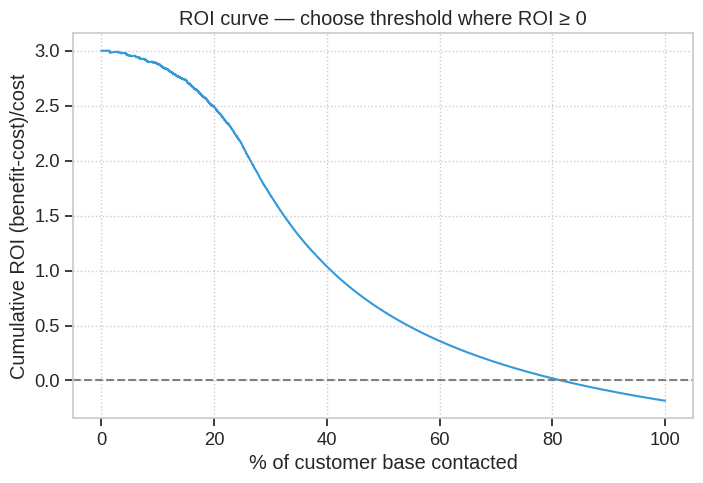

In [27]:
df_sorted = df_score.sort_values("proba", ascending=False).reset_index(drop=True)
df_sorted["cum_contacts"]   = np.arange(1, len(df_sorted)+1)
df_sorted["cum_churners"]   = df_sorted["actual"].cumsum()
df_sorted["cum_saved"]      = df_sorted["cum_churners"] * save_rate
df_sorted["cum_benefit"]    = df_sorted["cum_saved"] * save_value
df_sorted["cum_cost"]       = df_sorted["cum_contacts"] * offer_cost
df_sorted["cum_roi"]        = (df_sorted["cum_benefit"] - df_sorted["cum_cost"]) / df_sorted["cum_cost"]

plt.figure(figsize=(8,5))
plt.plot(df_sorted["cum_contacts"]/len(df_sorted)*100, df_sorted["cum_roi"])
plt.axhline(0, color="grey", linestyle="--")
plt.xlabel("% of customer base contacted")
plt.ylabel("Cumulative ROI (benefit-cost)/cost")
plt.title("ROI curve — choose threshold where ROI ≥ 0")
plt.grid(True, ls=":")
plt.show()

In [28]:
# Build a cumulative PROFIT curve and find the sweet spot
offer_cost  = 10        # $ per contact
save_value  = 200       # CLV protected when we save a churner
save_rate   = 0.20      # 20 % of contacted churners stay

df_sorted = df_score.sort_values("proba", ascending=False).reset_index(drop=True)

df_sorted["cum_contacts"] = np.arange(1, len(df_sorted)+1)
df_sorted["cum_churners"] = df_sorted["actual"].cumsum()
df_sorted["cum_saved"]    = df_sorted["cum_churners"] * save_rate
df_sorted["cum_benefit"]  = df_sorted["cum_saved"] * save_value
df_sorted["cum_cost"]     = df_sorted["cum_contacts"] * offer_cost
df_sorted["cum_profit"]   = df_sorted["cum_benefit"] - df_sorted["cum_cost"]

# Where is profit largest?
best_row         = df_sorted.loc[df_sorted["cum_profit"].idxmax()]
best_threshold   = best_row.name                # row index == #contacts − 1
best_pct_contact = best_row["cum_contacts"] / len(df_sorted) * 100
best_profit      = best_row["cum_profit"]

print(f"  Max profit @ {best_pct_contact:.1f}% of customers contacted")
print(f"  Probability score threshold ≈ {df_sorted.loc[best_row.name, 'proba']:.3f}")
print(f"  Expected profit: ${best_profit:,.0f}")

  Max profit @ 24.7% of customers contacted
  Probability score threshold ≈ 0.751
  Expected profit: $80,430


In [29]:
df_sorted.head()

,proba,actual,decile,cum_contacts,cum_churners,cum_saved,cum_benefit,cum_cost,cum_profit
0,0.843476,1.0,9,1,1.0,0.2,40.0,10,30.0
1,0.843389,1.0,9,2,2.0,0.4,80.0,20,60.0
2,0.843330,1.0,9,3,3.0,0.6,120.0,30,90.0
3,0.843324,1.0,9,4,4.0,0.8,160.0,40,120.0
4,0.843320,1.0,9,5,5.0,1.0,200.0,50,150.0


In [30]:
threshold = 0.726           # from the profit‑curve analysis
to_contact = df_score[df_score["proba"] >= threshold]

print(f"Contacts : {len(to_contact):,}")
print(f"Mean churn‑probability of this group: {to_contact['proba'].mean():.3f}")
to_contact.head()           # preview the highest‑risk rows

Contacts : 4,224
Mean churn‑probability of this group: 0.802


,proba,actual,decile
2,0.838545,1.0,9
12,0.833737,1.0,9
17,0.807523,0.0,8
22,0.811427,1.0,8
24,0.825845,1.0,8


#### Recommendation

| Segment | Prob. range (example) | Action |
|---------|----------------------|--------|
| Tier 1  | ≥ 0.85              | High-value personal call & premium offer |
| Tier 2  | 0.78 – 0.85         | Mid-touch call or personalised e-mail |
| Tier 3  | 0.726 – 0.78        | Low-cost nudge (SMS, app push) |

### 6.2  Personalise Interventions  
Explainability tools (e.g. *SHAP values*) tell *why* each customer scores high.

Combine the risk **probability** with the **reason code** to craft an offer most likely to retain that individual.


#### What is SHAP?
SHAP (SHapley Additive exPlanations) is a method to explain individual predictions of machine learning models. It tells you how much each feature contributed to pushing the prediction above or below the average prediction.

In [31]:
import shap
shap.initjs()

In [32]:
# 1) Fit SHAP explainer (tree‑based model explainer is fast)
explainer   = shap.TreeExplainer(clf_best)
shap_values = explainer.shap_values(X_label)        # returns array [n_samples, n_features]

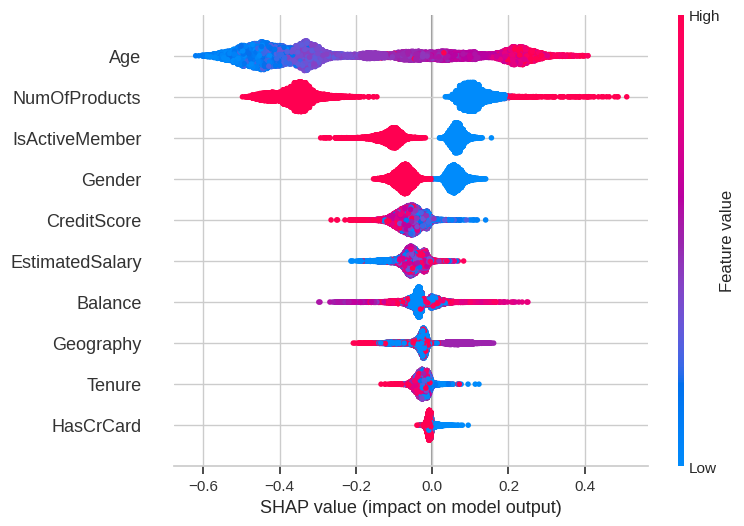

In [33]:
shap.summary_plot(shap_values, X_label)

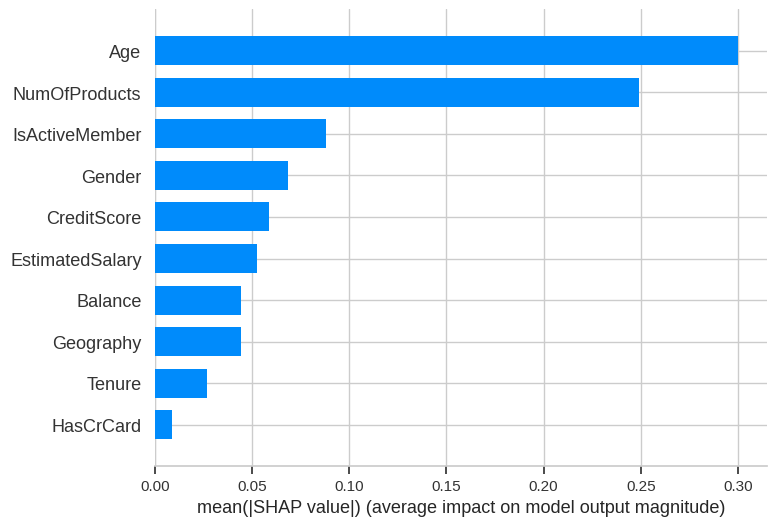

In [34]:
shap.summary_plot(shap_values, X_label, plot_type="bar")

In [35]:
shap.force_plot(explainer.expected_value, shap_values[0], X_label.iloc[0])

In [36]:
# 2) Retention tactic playbook  —  tailor offer to top‑SHAP reason
tactic_map = {
    # ─────────────────────────────────── AGE ───────────────────────────────────
    "Age<30"        : "🎓 Young-adult pack: fee-free account + cashback on streaming & ride‑share",
    "Age30-55"      : "🏠 Mid-career perks: mortgage rate review + bundled credit‑card rewards",
    "Age>55"        : "🛡️ Retirement concierge: priority phone line + wealth‑planning session",

    # ────────────────────────────── NUM OF PRODUCTS ───────────────────────────
    "NumProd=1"     : "➕ Cross-sell second product (savings or credit card) with 6‑month fee waiver",
    "NumProd=2-3"   : "🎁 'Bundle & Save' loyalty upgrade — combine products for lower fees",
    "NumProd>3"     : "💎 VIP umbrella plan: dedicated advisor + premium support",

    # ───────────────────────────── IS ACTIVE MEMBER ───────────────────────────
    "Inactive"      : "🔔 Win-back campaign: push/app/email nudge + one‑click re‑engagement bonus",
    "ActiveLowUse"  : "📊 Usage insights e-mail + personalised budgeting tools",
    
    # ───────────────────────────────── GENDER ─────────────────────────────────
    "Gender=Female" : "👩‍💼 Women‑focused benefits: childcare‑friendly branch hours + partner retail discounts",
    # (If your SHAP shows men less risky, you might skip a special tactic here.)

    # ──────────────────────────────── BALANCE ────────────────────────────────
    "Balance=Zero"  : "💸 Direct‑deposit bounty: $50 bonus for first payroll deposit",
    "Balance<25k"   : "📈 Micro‑savings roundup feature + monthly prize draw",
    "Balance>25k"   : "🏦 Relationship manager call + 0.25 % premium savings rate",
    
    # ─────────────────────────────── GEOGRAPHY ───────────────────────────────
    "Geo=Germany"   : "🇩🇪 Localised outreach call (native German) + tax‑efficient savings brochure",
    "Geo=France"    : "🇫🇷 Loyalty card with airline/train point multipliers",
    "Geo=Spain"     : "🇪🇸 Mobile push (Spanish) + summer holiday spending cashback",
}

def make_key(feature, value):
    """
    Quick helper that turns (feature, raw_value) into the lookup key above.
    Extend with your own binning rules as you refine segments.
    """
    if feature == "Age":
        if value < 30:   return "Age<30"
        elif value <= 55: return "Age30‑55"
        else:             return "Age>55"
    
    if feature == "NumOfProducts":
        if value == 1:      return "NumProd=1"
        elif value <= 3:    return "NumProd=2‑3"
        else:               return "NumProd>3"
    
    if feature == "IsActiveMember":
        return "Inactive" if value == 0 else "ActiveLowUse"
    
    if feature == "Gender":
        return "Gender=Female" if value == "Female" else "Gender=Male"
    
    if feature == "Balance":
        if value == 0:         return "Balance=Zero"
        elif value < 25_000:   return "Balance<25k"
        else:                  return "Balance>25k"
    
    if feature == "Geography":
        return f"Geo={value}"
    
    # fallback key if nothing matches
    return feature


def recommend_action(idx):
    """Return tactic for customer *idx* based on top SHAP reason."""
    contrib = np.abs(shap_values[idx])
    top_i   = contrib.argmax()
    top_feat = X_label.columns[top_i]
    raw_val  = X_label.iloc[idx, top_i]
    
    key   = make_key(top_feat, raw_val)
    offer = tactic_map.get(key, "Generic retention offer")
    
    return {
        "customer_index"  : idx,
        "churn_probability": proba[idx],
        "top_reason"      : f"{top_feat} = {raw_val}",
        "tactic_key"      : key,
        "suggested_action": offer
    }

In [37]:
# 3) Function to generate recommendation for a single customer
feature_names = X_label.columns.to_list()

# 4) Example — generate actions for high‑risk customers
high_risk_idx = df_score.sort_values("proba", ascending=False).head(40).index
actions = [recommend_action(i) for i in high_risk_idx]
pd.DataFrame(actions)

,customer_index,churn_probability,top_reason,tactic_key,suggested_action
0,11831,0.843476,Age = 52.0,Age30‑55,Generic retention offer
1,1155,0.843389,Age = 57.0,Age>55,🛡️ Retirement concierge: priority phone line +...
2,1477,0.843330,Age = 53.0,Age30‑55,Generic retention offer
3,160,0.843324,Age = 55.0,Age30‑55,Generic retention offer
4,3164,0.843320,Age = 53.0,Age30‑55,Generic retention offer
5,12462,0.843168,Age = 52.0,Age30‑55,Generic retention offer
6,3546,0.843134,Age = 55.0,Age30‑55,Generic retention offer
7,10813,0.842977,Age = 57.0,Age>55,🛡️ Retirement concierge: priority phone line +...
8,9088,0.842908,Age = 50.0,Age30‑55,Generic retention offer
9,5429,0.842737,NumOfProducts = 3.0,NumProd=2‑3,Generic retention offer


---
*End of notebook*